The difference between Local Field Potential (LFP) and Multi-Unit Activity (MUA) lies in what neural signals they represent, how they are recorded, and what they reflect about neural processing:

| Feature              | **LFP (Local Field Potential)**                           | **MUA (Multi-Unit Activity)**                           |
| -------------------- | --------------------------------------------------------- | ------------------------------------------------------- |
| **What it captures** | Low-frequency extracellular voltage fluctuations          | High-frequency voltage events related to spiking        |
| **Frequency range**  | \~0.1 to 300 Hz                                           | \~300 Hz to 5000 Hz                                     |
| **Neural origin**    | Summed synaptic currents (e.g., post-synaptic potentials) | Action potentials (spikes) from multiple nearby neurons |

<br><br>
#### Signal Extraction
<br>

##### LFP:

Obtained by low-pass filtering raw extracellular signals (cutoff ~300 Hz).

##### MUA:

Obtained by high-pass filtering (>300 Hz), then detecting threshold-crossing events.

Not sorted into individual neurons — it reflects pooled spike activity.
<br><br>


#### Analogy 
**LFP** is like listening to the murmur of a crowd — you hear collective activity and rhythms.

**MUA** is like counting how many people shout — you detect distinct burst events from several people nearby.

To collect **LFP** and **MUA**, you record from the same extracellular electrodes, but apply different filters and processing steps to separate the low-frequency (LFP) and high-frequency (MUA) components. 
<br><br>

In [182]:
!pip install umap-learn

  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/3c/8f/671c0e1f2572ba625cbcc1faeba9435e00330c3d6962858711445cf1e817/umap_learn-0.5.7-py3-none-any.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/d2/53/d23a97e0a2c690d40b165d1062e2c4ccc796be458a1ce59f6ba030434663/pynndescent-0.5.13-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ------------------------------------ --- 81.9/88.8 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 88.8/88.8 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import spectrogram
from scipy.io import savemat
import scipy.signal as signal
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
kilosort_spike = loadmat(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\Kilosort_spks.mat')
# 622

In [3]:
print(kilosort_spike.keys())
print(kilosort_spike['Mua'].shape)  # multi unit acitvity

dict_keys(['__header__', '__version__', '__globals__', 'Mua', 'snips', 'codes', 'labels'])
(1, 32)


In [4]:
print(kilosort_spike['Mua'][0,0])

[]


In [5]:
kilosort_spike['Mua'][0,1]

array([[1.66543360e-01],
       [2.60669440e-01],
       [2.92782080e-01],
       ...,
       [4.06985855e+03],
       [4.06989287e+03],
       [4.06993224e+03]])

In [6]:
kilosort_spike['Mua'][:,1]

array([array([[1.66543360e-01],
              [2.60669440e-01],
              [2.92782080e-01],
              ...,
              [4.06985855e+03],
              [4.06989287e+03],
              [4.06993224e+03]])], dtype=object)

In [7]:
kilosort_spike['Mua'][0,1].size

78700

In [8]:
kilosort_spike['Mua'][0, 2].size

0

In [9]:
trial_data = loadmat(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\trial_info.mat')

In [10]:
trial_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trialinfo'])

In [11]:
trial_data['trialinfo'].shape

(1, 2)

In [12]:
trial_data['trialinfo'][0,0].dtype.names

('TSClean', 'TSMasked')

In [13]:
#trial_data['trialinfo'][0,0]['TSClean']

In [14]:
time_point = [trial_data['trialinfo'][0,0]['TSClean'][i][0] for i in range(4)]

In [15]:
(len(time_point))

4

In [16]:
time_point[0]

array([[ 142.03301215],
       [ 287.032938  ],
       [ 477.03284073],
       [ 627.03276372],
       [ 972.03258729],
       [1162.03249002],
       [1217.03246164],
       [1412.03236198],
       [1642.03224421],
       [1812.03215718]])

In [17]:
spikes = kilosort_spike['Mua'][0,1]      # Channel 2
angle_dict = {}   # key: four angles     value: ten lists 
for i in range(len(time_point)):
    for time in time_point[i]:
        mask = ((time-1) < kilosort_spike['Mua'][0,1]) & (kilosort_spike['Mua'][0,1] < (time+4))
        
        selected_spikes = spikes[mask]  
        if i + 1 not in angle_dict:
            angle_dict[i + 1] = []
        angle_dict[i + 1].append(selected_spikes.tolist())
# print(angle_dict.keys())
# print(len(angle_dict[1]))
# print(angle_dict[1][0])        

In [18]:
time_point

[array([[ 142.03301215],
        [ 287.032938  ],
        [ 477.03284073],
        [ 627.03276372],
        [ 972.03258729],
        [1162.03249002],
        [1217.03246164],
        [1412.03236198],
        [1642.03224421],
        [1812.03215718]]),
 array([[ 157.03300452],
        [ 282.03294039],
        [ 582.03278685],
        [ 802.03267431],
        [ 882.0326333 ],
        [1092.03252578],
        [1257.03244138],
        [1552.03229022],
        [1682.0322237 ],
        [1922.03210068]]),
 array([[  37.0330658 ],
        [ 367.032897  ],
        [ 532.03281236],
        [ 607.03277397],
        [ 857.03264618],
        [1172.03248477],
        [1367.03238487],
        [1492.03232098],
        [1772.03217769],
        [1987.03206754]]),
 array([[ 162.0330019 ],
        [ 372.03289437],
        [ 517.03282022],
        [ 752.03269982],
        [ 887.03263068],
        [1132.03250527],
        [1207.03246689],
        [1482.03232598],
        [1767.03218007],
        [1957.03208

In [19]:
normalized_angle_dict = {}   # key: four angles     values: each keys contain ten lists
for angle_idx in range(len(angle_dict)):
    for trial_idx in range(len(angle_dict[angle_idx+1])):     # ten trials
        normalized_time = angle_dict[angle_idx+1][trial_idx]-time_point[angle_idx][trial_idx]
        if angle_idx+1 not in normalized_angle_dict:
            normalized_angle_dict[angle_idx+1]=[]
        normalized_angle_dict[angle_idx+1].append(normalized_time)
#print(normalized_angle_dict.keys())     
# print(normalized_angle_dict[1])  
#print(len(normalized_angle_dict[1]))

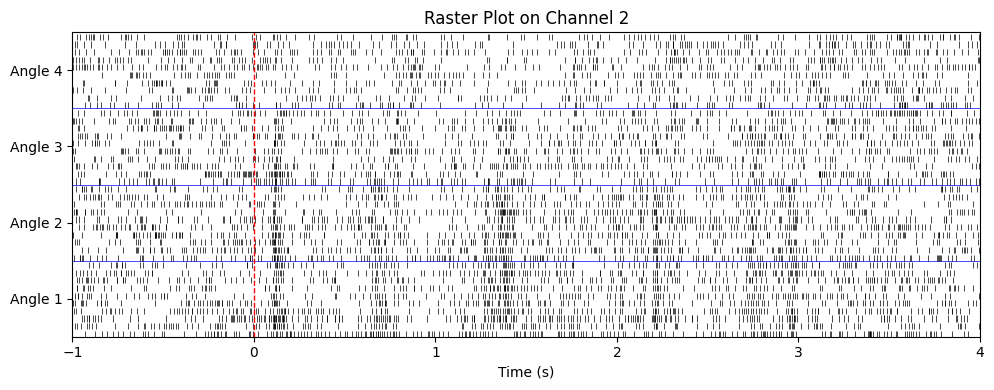

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

yticks = []
yticklabels = []
y_spacing = 1  # vertical spacing between angle rows

current_y = 0  # Y-axis tracker

# sorted: Ensures the keys are in ascending order
for angle in sorted(normalized_angle_dict.keys()):
    #base_y = i * y_spacing
    trials = normalized_angle_dict[angle]

    for trial in trials:
        for spike_time in trial:
            # plt.vlines(x, ymin, ymax, ...): draws one or more vertical lines at specified x-values, from ymin to ymax
            # current_y: This is the bottom y-coordinate of the line — the vertical position corresponding to the current trial row.
            # current_y + 0.8: This gives the spike a short vertical height so it's visually distinct, like a tick. 
            plt.vlines(spike_time, current_y, current_y + 0.8, color='black', linewidth=0.5)
        
        # after each trial, increment the current y value by 1
        current_y += y_spacing
    
    
    # After each angle, add label in the middle of the 10 trials for this angle
    plt.axhline(current_y, color='b', linestyle='-', linewidth=0.5)
    mid_y = current_y - (len(trials) * y_spacing) / 2
    yticks.append(mid_y)
    yticklabels.append(f'Angle {angle}')

# Axis formatting
plt.yticks(yticks, yticklabels)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Time (s)")
plt.title("Raster Plot on Channel 2")
plt.tight_layout()
plt.xlim(-1, 4)
plt.ylim(0, current_y)
plt.show()

<br><br>
🎯 Purpose of Using Bins in Spike Analysis:
When analyzing spike trains (especially across trials), raw spike times can be dense and messy. Binning helps you structure the data into meaningful time windows.
<br><br>

✅ Why Binning Is Useful:
1. Convert Events into Rates or Counts
Binning allows you to count how many spikes occurred in each time window:

From a list of exact spike times: [0.02, 0.05, 0.11, 0.51, ...]

To something structured like:
[bin 0-0.05s → 2 spikes, bin 0.05–0.10s → 1 spike, ...]

👉 This enables you to calculate:

Spike rate (Hz): count / bin width

Firing patterns over time (like ramping or bursts)
<br><br>

In [21]:
print(normalized_angle_dict.keys())

dict_keys([1, 2, 3, 4])


In [22]:
print(len(normalized_angle_dict[1]))

10


In [23]:
bin_size = 0.03
bin_trial = np.zeros(int(5/bin_size))
len(bin_trial)

166

In [24]:
bin_idx = int(-0.1/bin_size)
bin_idx

-3

In [25]:
bin_idx = int(0.1/bin_size)
bin_idx

3

In [26]:
bin_idx = 0.1//bin_size
bin_idx

3.0

In [27]:
print(type(normalized_angle_dict[1]))

<class 'list'>


In [28]:
print(len(normalized_angle_dict[1]))

10


In [29]:
#normalized_angle_dict[1][0]

In [30]:
len(normalized_angle_dict[1][0])

223

In [31]:


bin_size = 0.02

bin_dict = {}       # key: four angles      value: ten lists in each angle 
for angle in normalized_angle_dict.keys():
    bin_dict[angle] = []
    for trial in normalized_angle_dict[angle]:  # trial is a list
        bin_trial = np.zeros(int(5/bin_size))

        for timepoint in trial:
            bin_idx = int((timepoint+1)/bin_size)
            
            if 0 < bin_idx < len(bin_trial):      
                bin_trial[bin_idx] += 1

        bin_dict[angle].append(bin_trial)
# print(bin_dict[1])
# print(bin_dict.keys())           
        
        

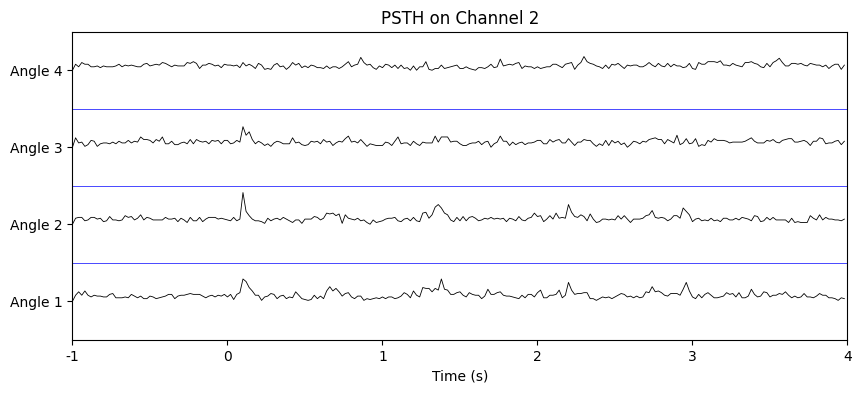

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

yticks = []
yticklabels = []


y_spacing = 9  # vertical spacing between angle rows

current_y = 0  # Y-axis tracker

# sorted: Ensures the keys are in ascending order
for angle in sorted(bin_dict.keys()):
    trials = np.array(bin_dict[angle])
#     print(np.array(np.sum(trials, axis=0)))
#     print(np.array(np.sum(trials, axis=0)).shape)
    
    #plt.plot(np.array(np.sum(trials, axis=0))+current_y)
    current_y += len(trials)*y_spacing
    plt.axhline(current_y, color='b', linestyle='-', linewidth=0.5)
    
    mid_y = current_y - (len(trials) * y_spacing) / 2
    yticks.append(mid_y)
    yticklabels.append(f'Angle {angle}')
    plt.plot(np.array(np.sum(trials, axis=0))+mid_y, color='k', linewidth= 0.6)
    



labels = ['-1', '0', '1', '2', '3', '4'] 
ticks = np.linspace(0, int(5/bin_size), 6)
plt.yticks(yticks, yticklabels)
plt.xticks(ticks, labels)
plt.xlabel("Time (s)")
plt.title("PSTH on Channel 2")
plt.xlim(0, int(5/bin_size))
plt.ylim(0, current_y)
plt.show()

Loop through all 32 channels and respectively average signal in different angles

In [31]:
# clean anesthetized   target 1

In [99]:
kilosort_spike = loadmat(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\Kilosort_spks.mat')
trial_data = loadmat(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\trial_info.mat')

In [100]:
class Mua:
    
    def __init__(self, kilosort_spike, idx_channels, trial_data, condition, trial_row, trial_column, trial_idx, fs = 24414.0625 / 20):
        """
        Initialize the Signal object with signal and trial data.

        Args:
            sig_data (ndarray): Array of signal recordings with the shape of (4968346, 32).
            trial_data (dict): Trial metadata loaded from a .mat file.
            condition (str): 'TSClean', 'TSMasked'
            trial_row (int): Row index for accessing trial data(only has 0, just one row).
            trial_column (int): Column index for accessing trial data(contain 0 and 1, two column: awake and anethetized)
            trial_idx (int): target 1 or target 2.
            fs (float, optional): Sampling frequency of the signal. Defaults to 24414.0625 / 20.
        """
        self.kilosort_spike = kilosort_spike
        self.idx_channels = idx_channels
        self.trial_data = trial_data
        self.condition = condition
        self.trial_row = trial_row
        self.trial_column = trial_column
        self.trial_idx = trial_idx
        self.fs = fs
        
    def slicing_and_concatenate(self):
        
        """
        Extracts and concatenates trial onset timestamps in trial_data

        trial_info: with the shape of (4, 2)

        Returns:
            np.ndarray: A 1D array of concatenated onset times from 4 angles with the specific trial_idx either target 1 or
            target 2.           .
        """
        trial_info = self.trial_data['trialinfo'][self.trial_row, self.trial_column][self.condition]
        time_point = [trial_info[i][self.trial_idx] for i in range(4)]    # 10 timestamps for each angle; 4 angles 

        return time_point # a list of four list each representing an angle    
        
        
    def to_create_angle_dict(self):
        
        """
         Generate a dictionary mapping stimulus angles to lists of spike times
        
        returns:
            dict: key: four angles     value: ten lists
            
        """
        time_point = self.slicing_and_concatenate()
        
        spikes = self.kilosort_spike['Mua'][self.trial_row, self.idx_channels]
        angle_dict = {}       # key: four angles     value: ten lists 
        for i in range(len(time_point)):
            for time in time_point[i]:
                
                # This creates a Boolean array (same length as spikes), where each entry is True if
                # the spike falls inside the window (time-1, time+4).
                # & compares each pair of elements at the same index,
                
                # You are operating on a NumPy array (spikes), so all comparisons and logical operations (<, &, etc.)
                # return a NumPy array — not a Python list
                mask = ((time-1) < spikes) & (spikes < (time+4))

                
                # Applies the mask to get only those spikes that fall into the specified window.
                selected_spikes = spikes[mask]  
                if i + 1 not in angle_dict:
                    angle_dict[i + 1] = []
                angle_dict[i + 1].append(selected_spikes.tolist())
        #print(angle_dict.keys())
        #print(len(angle_dict[1]))
        #print(angle_dict[1][0])
        return angle_dict
        
    
    def to_create_normalized_angle_dict(self):
        """
        Generate a dictionary of spike times normalized to stimulus onset times for each angle and trial.
        
        returns:
            dict: key: four angles     value: ten lists(items in each list is between -1s to 4s)
        
        
        """
        angle_dict = self.to_create_angle_dict()
        normalized_angle_dict = {}   # key: four angles     values: each keys contain ten lists
        for angle_idx in range(len(angle_dict)):
            for trial_idx in range(len(angle_dict[angle_idx+1])):     # ten trials
                normalized_time = angle_dict[angle_idx+1][trial_idx]-time_point[angle_idx][trial_idx]
                if angle_idx+1 not in normalized_angle_dict:
                    normalized_angle_dict[angle_idx+1]=[]
                normalized_angle_dict[angle_idx+1].append(normalized_time)
        #print(normalized_angle_dict.keys())
        return normalized_angle_dict
    
    
    def to_plot_raster_plot(self):
        
        """
        Plot a raster plot of normalized spike times across trials and angles.
        
        
        Returns:
            None. Displays a matplotlib raster plot.
        
        """
        
        # key: four angles     values: each keys contain ten lists
        normalized_angle_dict = self.to_create_normalized_angle_dict()
        

        plt.figure(figsize=(10, 4))

        yticks = []
        yticklabels = []
        y_spacing = 1  # vertical spacing between angle rows

        current_y = 0  # Y-axis tracker

        # sorted: Ensures the keys are in ascending order
        for angle in sorted(normalized_angle_dict.keys()):
            #base_y = i * y_spacing
            trials = normalized_angle_dict[angle]

            for trial in trials:
                for spike_time in trial:
                    # plt.vlines(x, ymin, ymax, ...): draws one or more vertical lines at specified x-values, from ymin to ymax
                    # current_y: This is the bottom y-coordinate of the line — the vertical position corresponding to the current trial row.
                    # current_y + 0.8: This gives the spike a short vertical height so it's visually distinct, like a tick. 
                    plt.vlines(spike_time, current_y, current_y + 0.8, color='black', linewidth=0.5)

                # after each trial, increment the current y value by 1
                current_y += y_spacing


            # After each angle, add label in the middle of the 10 trials for this angle
            plt.axhline(current_y, color='b', linestyle='-', linewidth=0.5)
            mid_y = current_y - (len(trials) * y_spacing) / 2
            yticks.append(mid_y)
            yticklabels.append(f'Angle {angle}')

        # Axis formatting
        plt.yticks(yticks, yticklabels)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
        plt.xlabel("Time (s)")
        plt.title(f"Raster Plot on Channel {self.idx_channels+1}")
        plt.tight_layout()
        plt.xlim(-1, 4)
        plt.ylim(0, current_y)
        plt.show()
    
    def to_get_bin_dict(self):
        
        """
            Convert normalized spike times into binned spike count arrays for each trial and angle.

            This method bins spikes into fixed-width bins (default = 20 ms) over a 5-second window 
            from -1s to +4s relative to stimulus onset. The result is a dictionary that contains 
            binned spike counts for each trial under each angle.

            Returns: dict: key: four angles   value: a numpy array for each trial (ten trials for each angle)
        """
        bin_size = 0.02
        bin_dict = {}
        normalized_angle_dict = self.to_create_normalized_angle_dict()
        for angle in normalized_angle_dict.keys():
            bin_dict[angle] = []
            for trial in normalized_angle_dict[angle]:  # trial is a list
                bin_trial = np.zeros(int(5/bin_size))

                for timepoint in trial:
                    bin_idx = int((timepoint+1)/bin_size)

                    if 0 < bin_idx < len(bin_trial):     
                        bin_trial[bin_idx] += 1

                bin_dict[angle].append(bin_trial)
        #print(bin_dict[1])
        #print(bin_dict.keys())
        return bin_dict
    
    
    
    def to_get_PSTH_signal(self):
        
        """
        Generate PSTH (Peri-Stimulus Time Histogram) signals for each stimulus angle.
        
        Returns:
            dict: key: angle      value: a numpy array for each angle 
        """
            
        bin_dict = self.to_get_bin_dict()        
        PSTH_signal_dict = {}


        # sorted: Ensures the keys are in ascending order
        for angle in sorted(bin_dict.keys()):
            trials = np.array(bin_dict[angle])
            signal = np.array(np.sum(trials, axis=0))
            #if np.all(signal != 0):
            PSTH_signal_dict[angle] = signal
            
        return PSTH_signal_dict
    
    
    


In [101]:
kilosort_spike['Mua'].shape

(1, 32)

In [102]:
normalized_angle_dict = Mua(kilosort_spike, 1, trial_data, 'TSClean', 0, 0, 0).to_create_normalized_angle_dict()

                     

In [103]:
time_point=Mua(kilosort_spike, 1, trial_data, 'TSClean', 0, 0, 0).slicing_and_concatenate()

In [37]:
#time_point

In [38]:
#normalized_angle_dict[1]

In [125]:
# key: No. of channels  value: {key: four angles   value: ten lists}

#(kilosort_spike, idx_channels, trial_data, condition, trial_row, trial_column, trial_idx)
print(kilosort_spike['Mua'].shape[1])
grand_bin_dict = {}

num_ch = 1
for ch in range(kilosort_spike['Mua'].shape[1]):
    if kilosort_spike['Mua'][0, ch].size != 0:
        grand_bin_dict[num_ch] = Mua(kilosort_spike, ch, trial_data, 'TSClean', 0, 0, 0).to_get_bin_dict()
        num_ch += 1
print(grand_bin_dict.keys())
print(len(grand_bin_dict[1][1]))

32
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
10


In [105]:
bin_dict = Mua(kilosort_spike, 1, trial_data, 'TSClean', 0, 0, 0).to_get_bin_dict()
print(bin_dict)

{1: [array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 2., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 3., 1., 2., 1., 1., 0., 1., 2., 0., 0., 2., 1., 0.,
       1., 0., 1., 1., 1., 2., 2., 1., 3., 1., 1., 2., 1., 1., 1., 0., 2.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 2., 1., 2., 0., 4., 1., 3.,
       2., 1., 1., 2., 1., 1., 1., 0., 1., 1., 1., 0., 1., 2., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 2., 2., 1., 1., 1., 2., 1., 1., 1., 0., 0.,
       0., 0., 1., 2., 1., 2., 1., 1., 1., 1., 2., 0., 0., 0., 1., 2., 1.,
       1., 2., 1., 1., 2., 1., 0., 1., 0., 1., 1., 2., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 2., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 2., 0., 2., 2., 0., 1., 0., 1., 1., 1., 1.,
       2., 1., 1., 3., 1., 1., 2., 2., 1., 1., 1., 2., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 0., 2., 1., 1., 0., 1., 0., 1., 0., 6., 1.,
       1., 1., 1., 1

In [40]:
#Mua(kilosort_spike, 1, trial_data, 'TSClean', 0, 0, 0).to_get_PSTH_signal()

In [126]:
channel_dict = {}   # key:  channels   value: dict{key: 4 angles value: PSTH signal for each angle}
for idx_ch in range(kilosort_spike['Mua'].shape[1]):
    if kilosort_spike['Mua'][0, idx_ch].size !=0:
        PSTH_signal_dict = Mua(kilosort_spike, idx_ch, trial_data, 'TSClean', 0, 0, 0).to_get_PSTH_signal()
        channel_dict[idx_ch+1] = PSTH_signal_dict
#print(channel_dict)
print(channel_dict.keys())

dict_keys([2, 4, 5, 7, 10, 14, 16, 18, 20, 22, 24, 25, 27, 30])


In [127]:
converted_to_angle_dict = {}  # key: 4 angles     value: 32 numpy array in each angle 
for ch in channel_dict.keys():
    for angle in range(1, 5):
        if angle not in converted_to_angle_dict:
            converted_to_angle_dict[angle] = []
        converted_to_angle_dict[angle].append(channel_dict[ch][angle])
# print(converted_to_angle_dict.keys())
# print(converted_to_angle_dict[2])
# print(len(converted_to_angle_dict[2]))
# print(type(converted_to_angle_dict[2][0]))

In [128]:
average_PSTH_signal_dict = {}
for angle in converted_to_angle_dict.keys():
    grand_PSTH_signal = np.array(converted_to_angle_dict[angle])
    print(grand_PSTH_signal.shape)
    average_PSTH_signal_dict[angle] = np.sum(grand_PSTH_signal, axis=0)/grand_PSTH_signal.shape[0]
# print(average_PSTH_signal_dict[1])
# print(average_PSTH_signal_dict[1].shape)

(14, 250)
(14, 250)
(14, 250)
(14, 250)


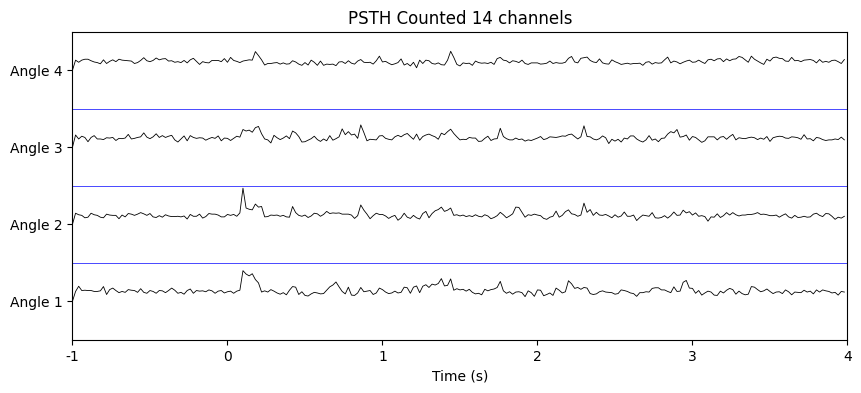

In [129]:

plt.figure(figsize=(10, 4))

yticks = []
yticklabels = []


y_spacing = 18  # vertical spacing between angle rows

current_y = 0  # Y-axis tracker

# sorted: Ensures the keys are in ascending order
for angle in sorted(average_PSTH_signal_dict.keys()):
    trials = np.array(bin_dict[angle])
#     print(np.array(np.sum(trials, axis=0)))
    
    
    #plt.plot(np.array(np.sum(trials, axis=0))+current_y)
    current_y += y_spacing
    plt.axhline(current_y, color='b', linestyle='-', linewidth=0.5)
    
    mid_y = current_y - y_spacing / 2
    yticks.append(mid_y)
    yticklabels.append(f'Angle {angle}')
    plt.plot(average_PSTH_signal_dict[angle]+mid_y, color='k', linewidth= 0.6)
    



labels = ['-1', '0', '1', '2', '3', '4'] 
ticks = np.linspace(0, int(5/bin_size), 6)
plt.yticks(yticks, yticklabels)
plt.xticks(ticks, labels)
plt.xlabel("Time (s)")
plt.title(f"PSTH Counted {len(channel_dict)} channels")
plt.xlim(0, int(5/bin_size))
plt.ylim(0, current_y)
plt.show()

In [130]:
# option 1
class PCA_option_1:
    
    # key: No. of channels  value: {key: four angles   value: ten lists}
    def __init__(self, grand_bin_dict, arbi_angle_1, arbi_angle_2, init_ch, num_channels): 
        self.grand_bin_dict = grand_bin_dict
        self.angle_1 = arbi_angle_1
        self.angle_2 = arbi_angle_2
        self.init_ch = init_ch
        self.number_channels = num_channels 
        
    def to_get_signal_for_specific_angle(self):
        

        # Angle 1 
        min_length_1 = min(epoch.shape[0] for i in range(self.init_ch, self.number_channels+1) for epoch in self.grand_bin_dict[i][self.angle_1])
   
        signal_1 = np.array([epoch[:min_length_1] for i in range(self.init_ch, self.number_channels+1) for epoch in self.grand_bin_dict[i][self.angle_1]])
        signal_1 = signal_1.reshape(10, -1)
  

        # Angle 2
        min_length_2 = min(epoch.shape[0] for i in range(self.init_ch, self.number_channels+1) for epoch in self.grand_bin_dict[i][self.angle_2])
 
        signal_2 = np.array([epoch[:min_length_2] for i in range(self.init_ch, self.number_channels+1) for epoch in self.grand_bin_dict[i][self.angle_2]])
        signal_2 = signal_2.reshape(10, -1)
 
        return signal_1, signal_2



    def to_fit_PCA_on_combined_data_and_split(self):
        
        signal_1, signal_2 = self.to_get_signal_for_specific_angle()
        # Fit PCA on combined data (recommended)
        X_combined = np.vstack([signal_1, signal_2])
        #print(X_combined.shape)
        pca = PCA(n_components=3)
        X_combined_reduced = pca.fit_transform(X_combined)

        #print(X_combined_reduced.shape)


        # Split back
        X1_reduced = X_combined_reduced[:10]
        X2_reduced = X_combined_reduced[10:]

        #print(X1_reduced.shape)
        #print(X2_reduced.shape)
        return X1_reduced, X2_reduced, X_combined_reduced
        
    def to_plot_3D_scatter(self):
        
        X1_reduced, X2_reduced = self.to_fit_PCA_on_combined_data_and_split()[:2]
        # 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # * unpacks the transposed array into three separate arguments
        # Transpose is needed to convert row-wise PCA data into three separate 1D arrays for 3D plotting.
        # X1_reduced.shape = (n_samples, n_components)
        # X1_reduced.T.shape = (n_components, n_samples)
        ax.scatter(*X1_reduced.T, color='blue', label='angle '+ str(self.angle_1), s=20)
        ax.scatter(*X2_reduced.T, color='orange', label='angle '+str(self.angle_2), s=20)

        ax.set_title(f"PCA Projection ({self.number_channels} Channels per Signal)")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.legend()
        plt.show()
        
        
    def to_apply_KMean(self):
        # Apply K-means clustering
        X1_reduced, X2_reduced, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        
        # Creates a KMeans object from scikit-learn.
        # n_clusters=2`: You want to find 2 clusters (corresponding to your 2 angles).
        # n_init=10`: The algorithm will run 10 times with different centroid seeds and return the best result.
        # random_state=0`: Ensures reproducibility (same clustering every time you run the code)
        kmeans = KMeans(n_clusters=2, n_init=50,random_state=0)
        
        # fit_predict() is a shorthand that:
        # Fits the KMeans model to the data (i.e., finds centroids).
        # Predicts the cluster label (either 0 or 1 in your case) for each sample.
        # The result labels is a NumPy array of length equal to the number of data points, assigning each point to one of the 2 clusters.
        labels = kmeans.fit_predict(X_combined_reduced)
        #print(labels)
        # Optional: true labels (for visual comparison only, not used by K-means)
        true_labels = np.array([0]*len(X1_reduced) + [1]*len(X2_reduced))
        


        acc_1 = accuracy_score(true_labels, labels)
        acc_2 = accuracy_score(true_labels, 1 - labels)  # flip 0↔1
        accuracy = max(acc_1, acc_2)
        #print(f"K-means Accuracy: {accuracy:.2f}")
        
        return accuracy,labels 

    def to_plot_KMean(self):
        _, _, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        _,labels = self.to_apply_KMean()
        # Plot in 3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # alpha=0.8 makes points semi-transparent
        ax.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], X_combined_reduced[:, 2], c=labels, cmap='coolwarm', alpha=0.8)
        ax.set_title(f"K-means Clustering in {self.number_channels} channels")
        plt.show()
        

{1: 1.0, 2: 0.55, 3: 0.5, 4: 0.55, 5: 0.5, 6: 0.55, 7: 0.85, 8: 0.7, 9: 0.95, 10: 0.65, 11: 0.55, 12: 0.55, 13: 0.9, 14: 0.55}


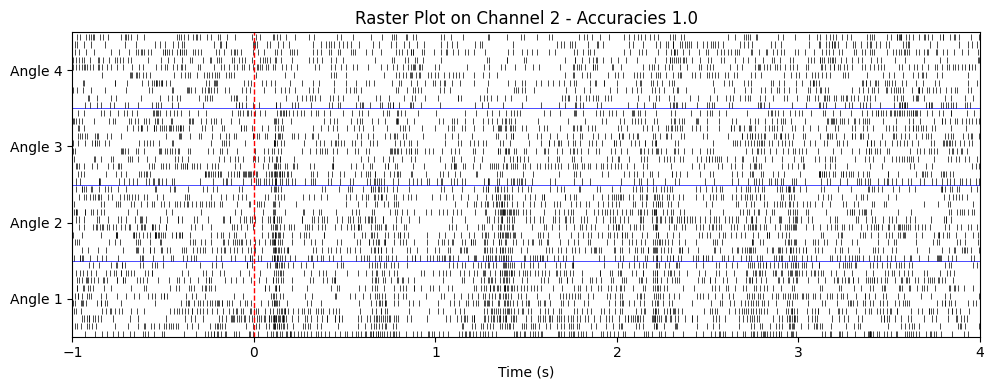

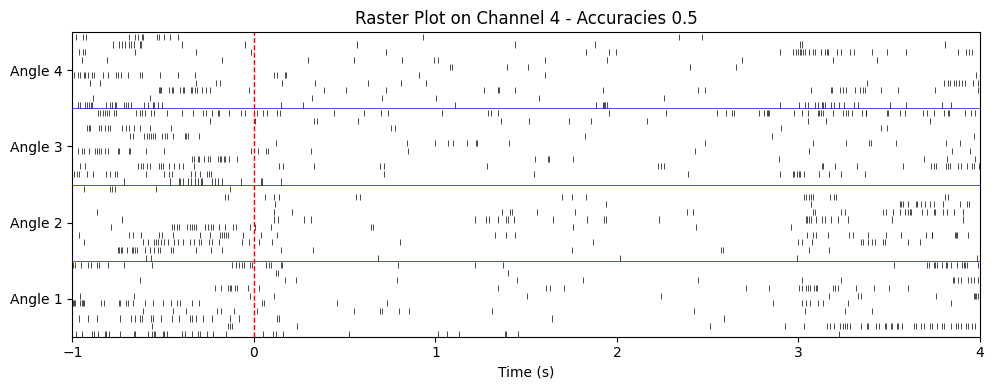

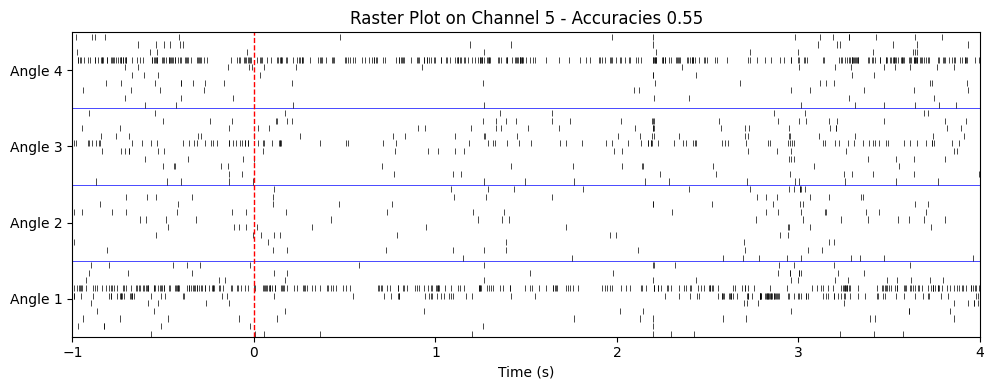

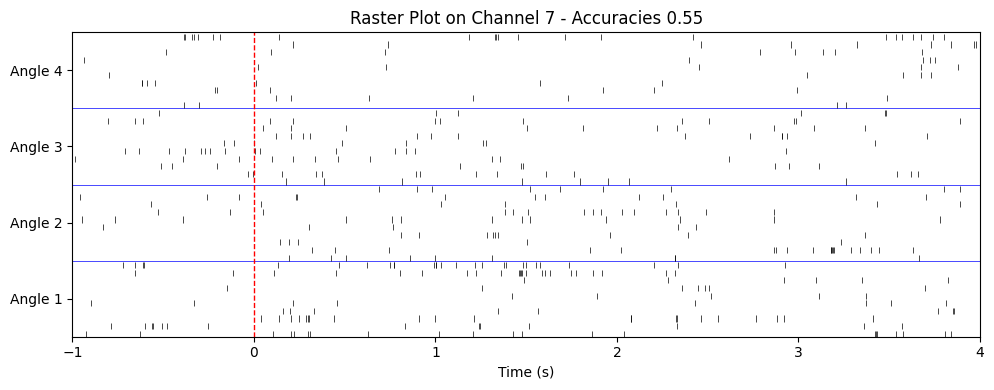

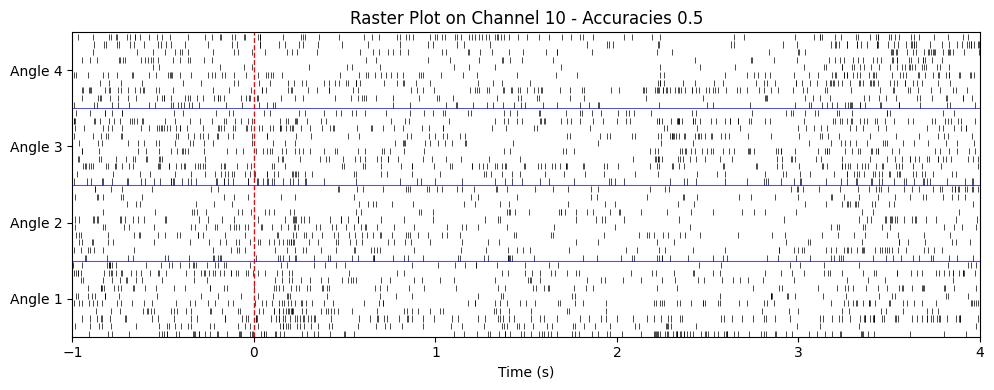

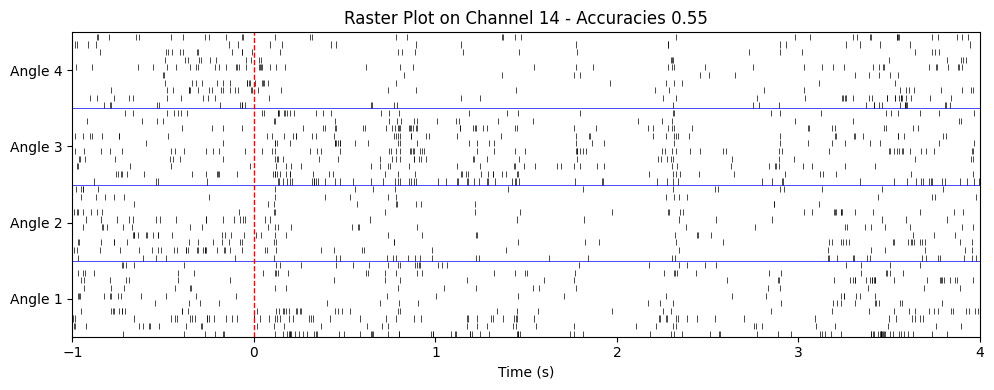

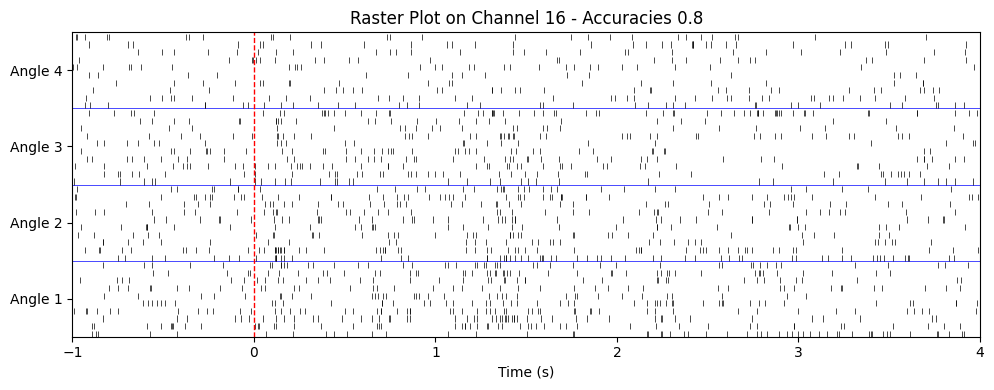

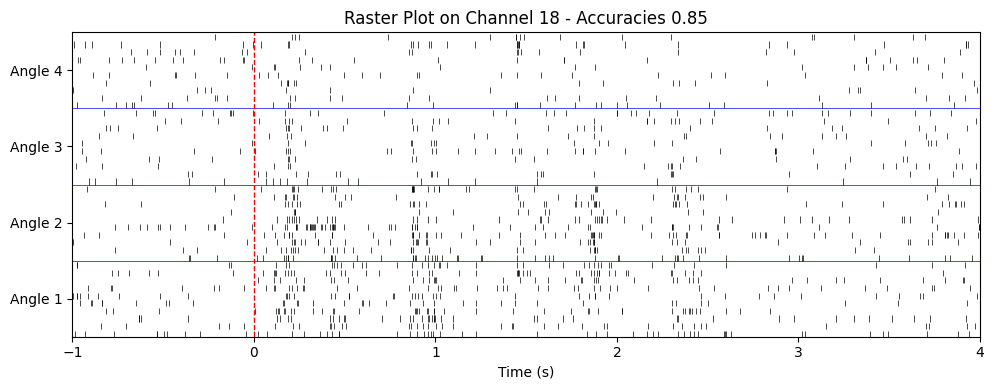

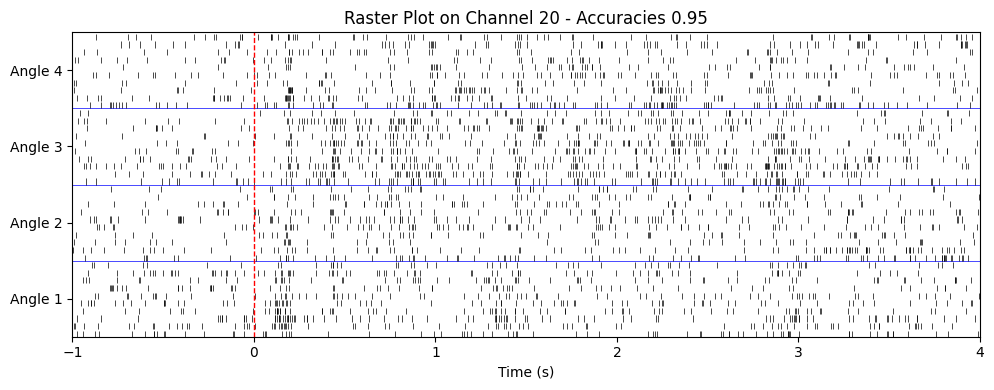

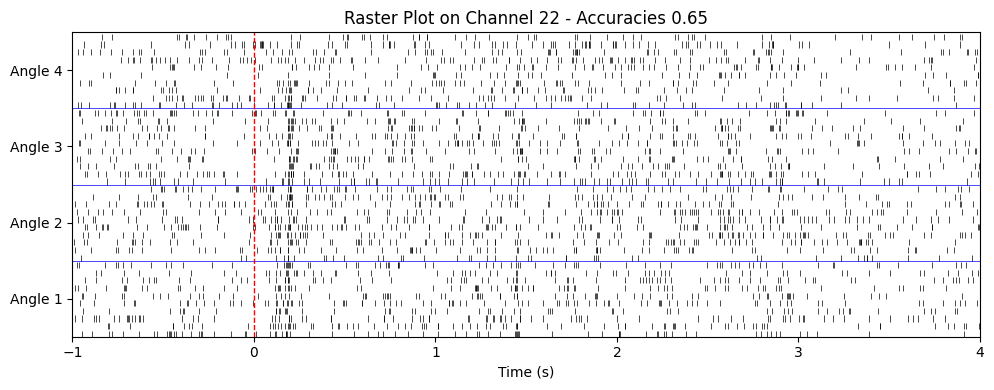

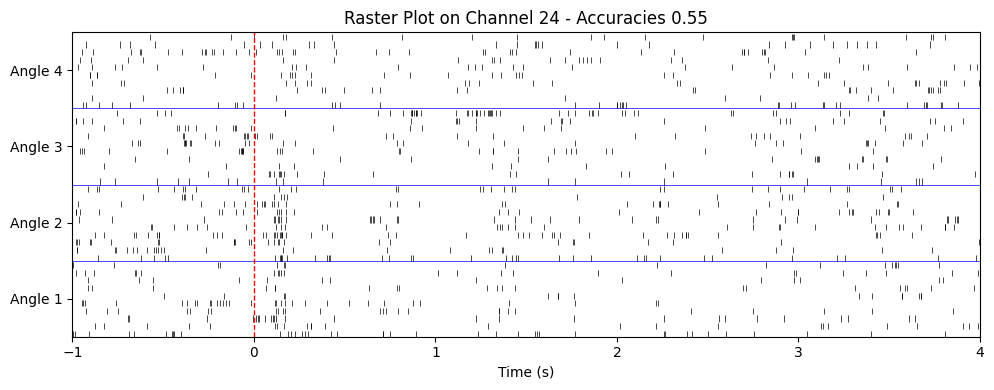

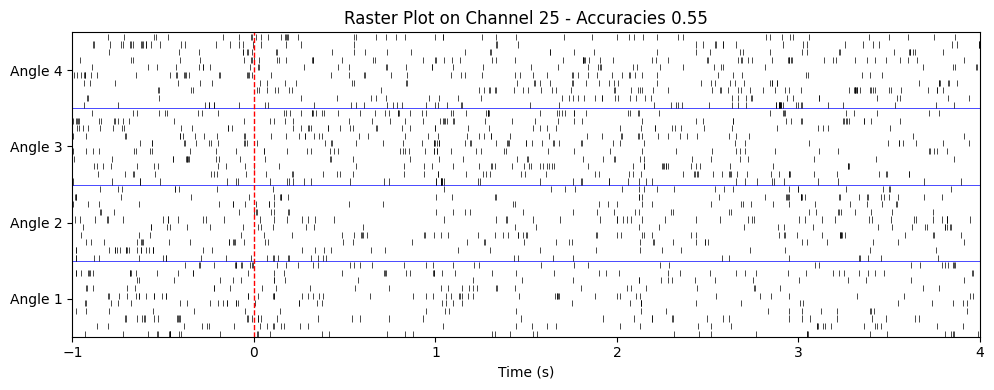

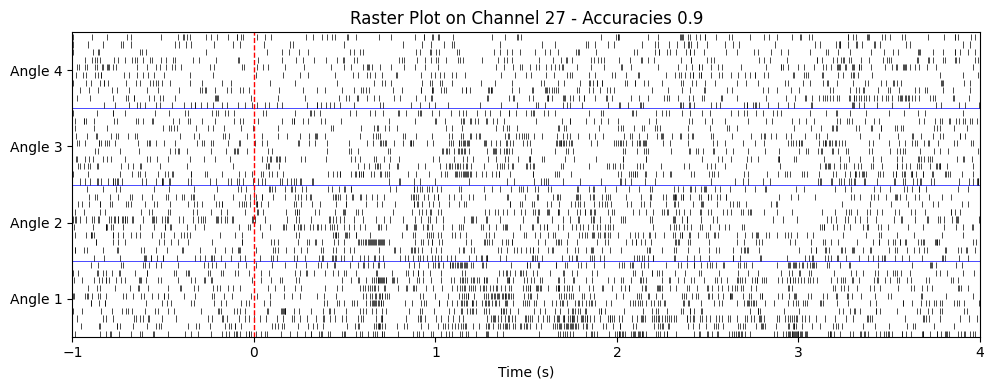

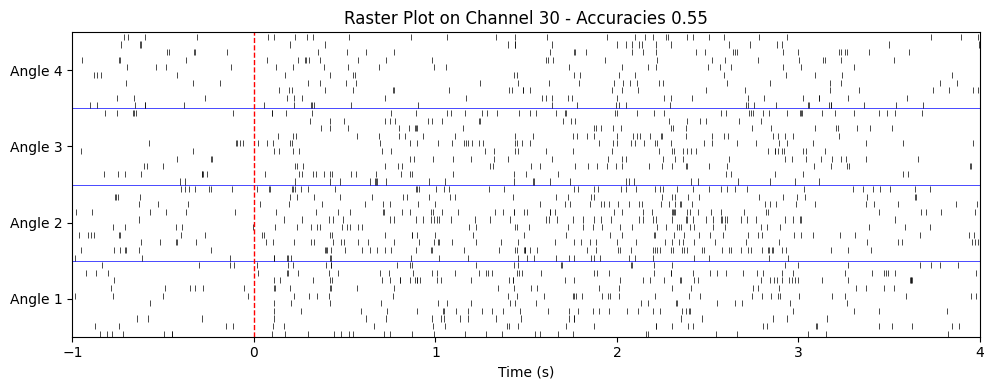

In [131]:
acc_cluster = {}
 
for ch in range(len(grand_bin_dict.keys())):   # key: No. of channels  value: {key: four angles   value: ten lists}
    acc = PCA_option_1(grand_bin_dict, 1, 4, ch+1, ch+1).to_apply_KMean()[0]
    acc_cluster[ch+1] = acc
print(acc_cluster)

retified_acc_cluster = {2: 1.0, 4: 0.5, 5: 0.55, 7: 0.55, 10: 0.5, 14: 0.55, 16: 0.8, 18: 0.85, 20: 0.95, 22: 0.65, 24: 0.55, 25: 0.55, 27: 0.9, 30: 0.55}

for idx_ch in range(kilosort_spike['Mua'].shape[1]):
    if kilosort_spike['Mua'][0, idx_ch].size !=0:

        normalized_angle_dict = Mua(kilosort_spike, idx_ch, trial_data, 'TSClean', 0, 0, 0).to_create_normalized_angle_dict()
        #acc = PCA_option_1(grand_bin_dict, 1, 4, idx_ch+1, idx_ch+1).to_apply_KMean()[0]
        plt.figure(figsize=(10, 4))

        yticks = []
        yticklabels = []
        y_spacing = 1  # vertical spacing between angle rows

        current_y = 0  # Y-axis tracker

        # sorted: Ensures the keys are in ascending order
        for angle in sorted(normalized_angle_dict.keys()):
            #base_y = i * y_spacing
            trials = normalized_angle_dict[angle]

            for trial in trials:
                for spike_time in trial:
                    # plt.vlines(x, ymin, ymax, ...): draws one or more vertical lines at specified x-values, from ymin to ymax
                    # current_y: This is the bottom y-coordinate of the line — the vertical position corresponding to the current trial row.
                    # current_y + 0.8: This gives the spike a short vertical height so it's visually distinct, like a tick. 
                    plt.vlines(spike_time, current_y, current_y + 0.8, color='black', linewidth=0.5)

                # after each trial, increment the current y value by 1
                current_y += y_spacing


            # After each angle, add label in the middle of the 10 trials for this angle
            plt.axhline(current_y, color='b', linestyle='-', linewidth=0.5)
            mid_y = current_y - (len(trials) * y_spacing) / 2
            yticks.append(mid_y)
            yticklabels.append(f'Angle {angle}')
        


        
        # Axis formatting
        plt.yticks(yticks, yticklabels)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
        plt.xlabel("Time (s)")
        plt.title(f"Raster Plot on Channel {idx_ch+1} - Accuracies {retified_acc_cluster[idx_ch+1]}")
        plt.tight_layout()
        plt.xlim(-1, 4)
        plt.ylim(0, current_y)
        plt.show()
        


<br><br>
### Concatenate the signals from multiple channels (7, 10, 24) into a single feature vector per trial:

### Each trial becomes a 750-dimensional vector, representing all channels jointly.

### PCA then projects these high-dimensional, joint-feature trials into a lower 3D space.

### K-means clusters are applied to this fused representation.

### ➡ This method captures inter-channel correlations and joint structure. It evaluates how well all channels together can help distinguish the two conditions (angles).

### The alternative method is to average accuracy over individual channel.  This tells you how informative each individual channel is, but ignores synergy across channels
<br>

In [132]:
### Channel 7
signal_1_ch7, signal_2_ch7 = PCA_option_1(grand_bin_dict, 1, 4, 4, 4).to_get_signal_for_specific_angle()

In [133]:
### Channel 10
signal_1_ch10, signal_2_ch10 = PCA_option_1(grand_bin_dict, 1, 4, 5, 5).to_get_signal_for_specific_angle()

In [134]:
### Channel 24
signal_1_ch24, signal_2_ch24 = PCA_option_1(grand_bin_dict, 1, 4, 11, 11).to_get_signal_for_specific_angle()

In [135]:
signal_1 = np.array([signal_1_ch7, signal_1_ch10, signal_1_ch24])
signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)
print(signal_1.reshape(10, -1).shape)
signal_2 = np.array([signal_2_ch7, signal_2_ch10, signal_2_ch24])
signal_2 = signal_2.reshape(10, -1)

(10, 750)
(10, 750)


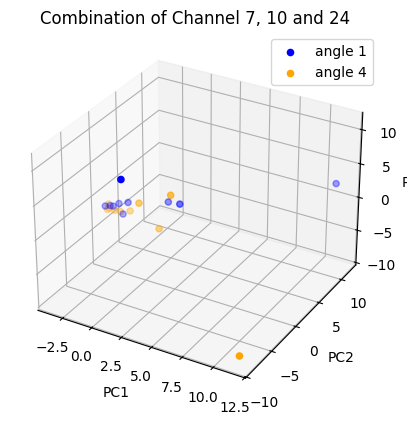

In [136]:
 X_combined = np.vstack([signal_1, signal_2])
#print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

#print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:10]
X2_reduced = X_combined_reduced[10:]

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='angle 1', s=20)
ax.scatter(*X2_reduced.T, color='orange', label='angle 4', s=20)

ax.set_title("Combination of Channel 7, 10 and 24")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()




In [137]:
kmeans = KMeans(n_clusters=2, n_init=10,random_state=0)

# fit_predict() is a shorthand that:
# Fits the KMeans model to the data (i.e., finds centroids).
# Predicts the cluster label (either 0 or 1 in your case) for each sample.
# The result labels is a NumPy array of length equal to the number of data points, assigning each point to one of the 2 clusters.
labels = kmeans.fit_predict(X_combined_reduced)
#print(labels)
# Optional: true labels (for visual comparison only, not used by K-means)
true_labels = np.array([0]*len(X1_reduced) + [1]*len(X2_reduced))



acc_1 = accuracy_score(true_labels, labels)
acc_2 = accuracy_score(true_labels, 1 - labels)  # flip 0↔1
accuracy = max(acc_1, acc_2)
print(f"K-means Accuracy: {accuracy:.2f}")

K-means Accuracy: 0.55


<br><br>
### PCA on Different Combinations of Channels 

In [138]:
PCA_option_1(grand_bin_dict, 1, 4, 1, 1).to_get_signal_for_specific_angle()[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 2., 1., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

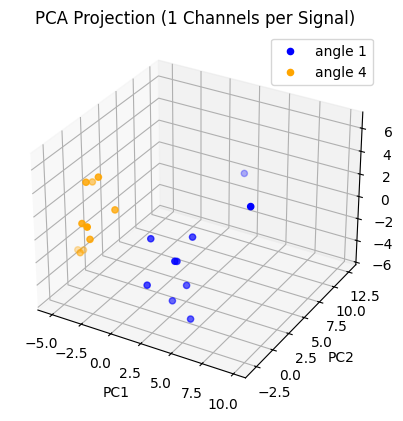

In [139]:
PCA_option_1(grand_bin_dict, 1, 4, 1, 1).to_plot_3D_scatter()

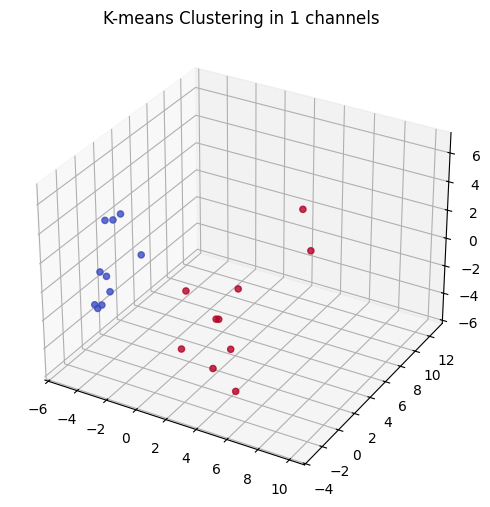

In [140]:
PCA_option_1(grand_bin_dict, 1, 4, 1, 1).to_plot_KMean()

[1.0, 0.5, 0.5, 0.6, 0.5, 0.5, 0.55, 0.55, 0.55, 0.55, 0.5, 0.5, 0.55, 0.55]


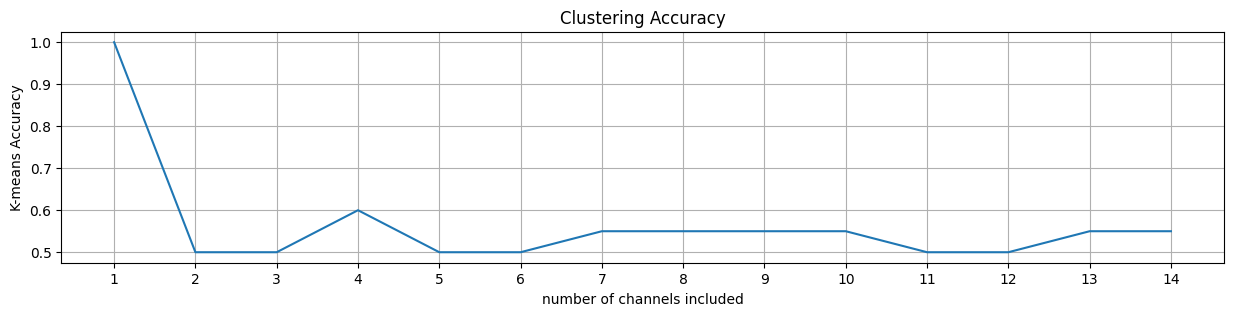

In [141]:
acc_cluster = []
for ch in range(len(grand_bin_dict.keys())):
    acc = PCA_option_1(grand_bin_dict, 1, 4, 1, ch+1).to_apply_KMean()[0]
    acc_cluster.append(acc)
print(acc_cluster)

plt.figure(figsize=(15, 3)) 
plt.plot(range(1, len(grand_bin_dict.keys())+1), acc_cluster)
plt.xticks(range(1, len(grand_bin_dict.keys())+1))  # Tick every 1 unit from 1 to 32
plt.xlabel('number of channels included')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy')
plt.grid(True)
plt.show()  

[1.0, 0.55, 0.5, 0.55, 0.5, 0.55, 0.85, 0.7, 0.95, 0.65, 0.55, 0.55, 0.9, 0.55]


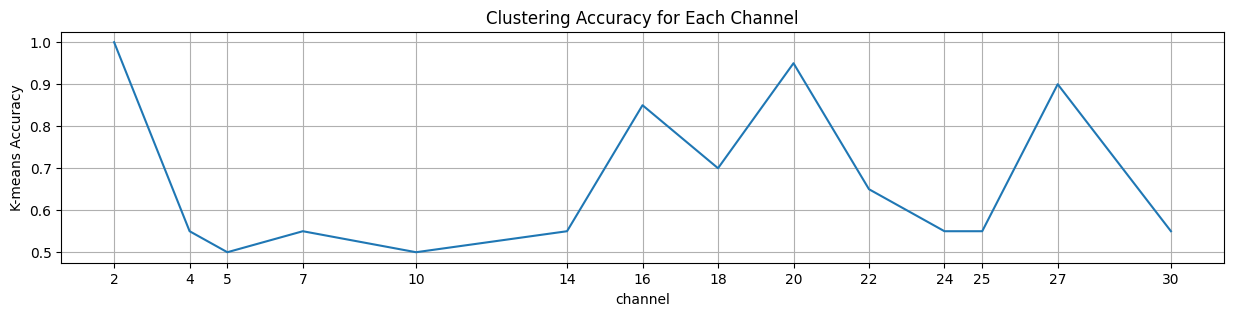

In [142]:
acc_cluster = []
for ch in range(len(grand_bin_dict.keys())):
    acc = PCA_option_1(grand_bin_dict, 1, 4, ch+1, ch+1).to_apply_KMean()[0]
    acc_cluster.append(acc)
print(acc_cluster)

plt.figure(figsize=(15, 3)) 
plt.plot(list(channel_dict.keys()), acc_cluster)
#plt.xticks(range(1, len(grand_bin_dict.keys())+1))  # Tick every 1 unit from 1 to 32
plt.xticks(list(channel_dict.keys()))
plt.xlabel('channel')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy for Each Channel')
plt.grid(True)
plt.show()  

1.0
0.55
0.5
0.55
0.5
0.55
0.85
0.7
0.95
0.65
0.55
0.55
0.9
0.55


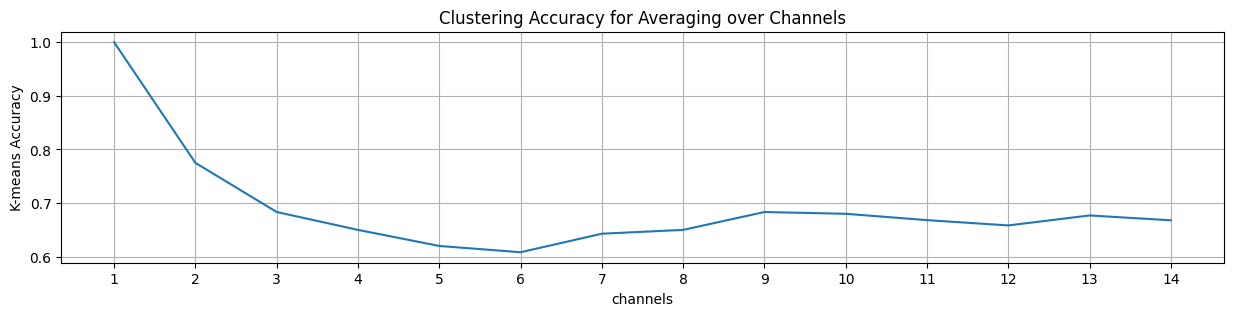

In [143]:
acc_cluster = []
mean = []
for ch in range(len(grand_bin_dict.keys())):
    acc = PCA_option_1(grand_bin_dict, 1, 4, ch+1, ch+1).to_apply_KMean()[0]
    print(acc)
    acc_cluster.append(acc)
    mean.append(np.mean(acc_cluster))


plt.figure(figsize=(15, 3)) 
plt.plot(range(1, len(grand_bin_dict.keys())+1), mean)
plt.xticks(range(1, len(grand_bin_dict.keys())+1))  # Tick every 1 unit from 1 to 32
plt.xlabel('channels')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy for Averaging over Channels')
plt.grid(True)
plt.show()  

<br><br>
## UMAP

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import umap.umap_ as umap  # Make sure umap-learn is installed
import warnings
warnings.filterwarnings("ignore", message="n_jobs value 1 overridden to 1 by setting random_state")


class UMAP_option_1:
    
    def __init__(self, grand_bin_dict, arbi_angle_1, arbi_angle_2, num_channels): 
        self.grand_bin_dict = grand_bin_dict
        self.angle_1 = arbi_angle_1
        self.angle_2 = arbi_angle_2
        self.number_channels = num_channels 
        
    def to_get_signal_for_specific_angle(self):
        # Angle 1
        min_length_1 = min(epoch.shape[0] for i in range(1, self.number_channels + 1) for epoch in self.grand_bin_dict[i][self.angle_1])
        signal_1 = np.array([epoch[:min_length_1] for i in range(1, self.number_channels + 1) for epoch in self.grand_bin_dict[i][self.angle_1]])
        signal_1 = signal_1.reshape(10, -1)

        # Angle 2
        min_length_2 = min(epoch.shape[0] for i in range(1, self.number_channels + 1) for epoch in self.grand_bin_dict[i][self.angle_2])
        signal_2 = np.array([epoch[:min_length_2] for i in range(1, self.number_channels + 1) for epoch in self.grand_bin_dict[i][self.angle_2]])
        signal_2 = signal_2.reshape(10, -1)

        return signal_1, signal_2

    def to_fit_UMAP_on_combined_data_and_split(self):
        signal_1, signal_2 = self.to_get_signal_for_specific_angle()
        X_combined = np.vstack([signal_1, signal_2])

        reducer = umap.UMAP(n_components=3, random_state=42)
        X_combined_reduced = reducer.fit_transform(X_combined)

        X1_reduced = X_combined_reduced[:10]
        X2_reduced = X_combined_reduced[10:]

        return X1_reduced, X2_reduced, X_combined_reduced

    def to_plot_3D_scatter(self):
        X1_reduced, X2_reduced = self.to_fit_UMAP_on_combined_data_and_split()[:2]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(*X1_reduced.T, color='blue', label='angle ' + str(self.angle_1), s=20)
        ax.scatter(*X2_reduced.T, color='orange', label='angle ' + str(self.angle_2), s=20)

        ax.set_title(f"UMAP Projection ({self.number_channels} Channels per Signal)")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.set_zlabel("UMAP3")
        ax.legend()
        plt.show()

    def to_apply_KMean(self):
        X1_reduced, X2_reduced, X_combined_reduced = self.to_fit_UMAP_on_combined_data_and_split()

        kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
        labels = kmeans.fit_predict(X_combined_reduced)

        true_labels = np.array([0] * len(X1_reduced) + [1] * len(X2_reduced))
        acc_1 = accuracy_score(true_labels, labels)
        acc_2 = accuracy_score(true_labels, 1 - labels)
        accuracy = max(acc_1, acc_2)

        return accuracy, labels

    def to_plot_KMean(self):
        _, _, X_combined_reduced = self.to_fit_UMAP_on_combined_data_and_split()
        _, labels = self.to_apply_KMean()

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], X_combined_reduced[:, 2],
                   c=labels, cmap='coolwarm', alpha=0.8)

        ax.set_title(f"K-means Clustering (UMAP) in {self.number_channels} channels")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.set_zlabel("UMAP3")
        plt.show()


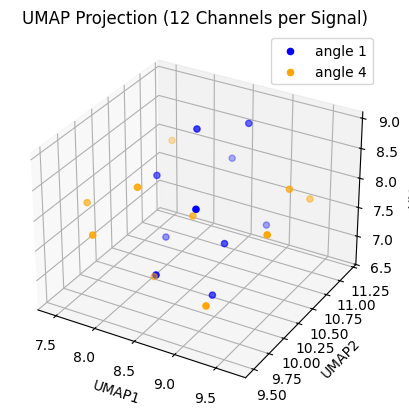

In [221]:
UMAP_option_1(grand_bin_dict, 1, 4, 12).to_plot_3D_scatter()

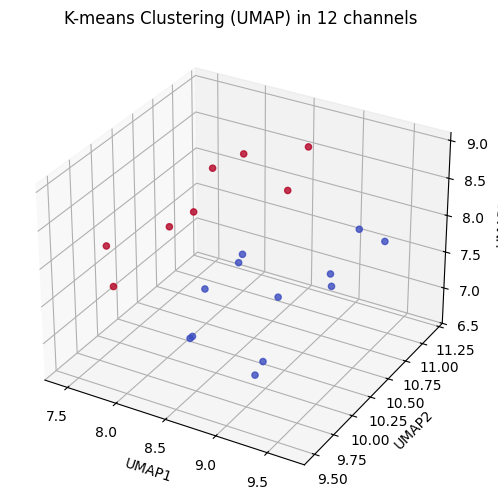

In [222]:
UMAP_option_1(grand_bin_dict, 1, 4, 12).to_plot_KMean()

[1.0, 0.75, 0.55, 0.55, 0.75, 0.5, 0.65, 0.65, 0.6, 0.55, 0.65, 0.5, 0.6, 0.55]


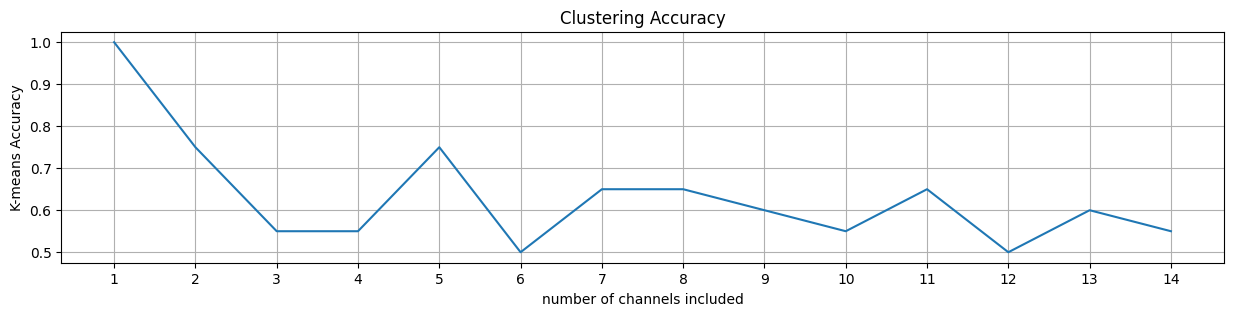

In [223]:
acc_cluster = []
for ch in range(len(grand_bin_dict.keys())):
    acc = UMAP_option_1(grand_bin_dict, 1, 4, ch+1).to_apply_KMean()[0]
    acc_cluster.append(acc)
print(acc_cluster)

plt.figure(figsize=(15, 3)) 
plt.plot(range(1, len(grand_bin_dict.keys())+1), acc_cluster)
plt.xticks(range(1, len(grand_bin_dict.keys())+1))  # Tick every 1 unit from 1 to 32
plt.xlabel('number of channels included')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy')
plt.grid(True)
plt.show()  

In [91]:
 # Angle 1 on channel 1-10

print(converted_to_angle_dict[1][0].shape)
converted_to_angle_dict[1][0].shape[0]    
    
for ch in range(1, len(channel_dict.keys())+1):   
    min_length_1 = min(converted_to_angle_dict[1][i].shape[0] for i in range(len(channel_dict.keys())))
    #print(min_length_1)
    signal_1 = np.array([converted_to_angle_dict[1][i][:min_length_1] for i in range(len(channel_dict.keys()))])
    print(signal_1)

(250,)
[[ 0.  7. 11. ...  1.  4.  3.]
 [ 0.  1.  6. ...  2.  5.  4.]
 [ 0.  3.  5. ...  2.  5.  4.]
 ...
 [ 0.  1.  1. ...  3.  1.  1.]
 [ 0.  2.  3. ...  2.  3.  4.]
 [ 0.  0.  0. ...  1.  1.  1.]]
[[ 0.  7. 11. ...  1.  4.  3.]
 [ 0.  1.  6. ...  2.  5.  4.]
 [ 0.  3.  5. ...  2.  5.  4.]
 ...
 [ 0.  1.  1. ...  3.  1.  1.]
 [ 0.  2.  3. ...  2.  3.  4.]
 [ 0.  0.  0. ...  1.  1.  1.]]
[[ 0.  7. 11. ...  1.  4.  3.]
 [ 0.  1.  6. ...  2.  5.  4.]
 [ 0.  3.  5. ...  2.  5.  4.]
 ...
 [ 0.  1.  1. ...  3.  1.  1.]
 [ 0.  2.  3. ...  2.  3.  4.]
 [ 0.  0.  0. ...  1.  1.  1.]]
[[ 0.  7. 11. ...  1.  4.  3.]
 [ 0.  1.  6. ...  2.  5.  4.]
 [ 0.  3.  5. ...  2.  5.  4.]
 ...
 [ 0.  1.  1. ...  3.  1.  1.]
 [ 0.  2.  3. ...  2.  3.  4.]
 [ 0.  0.  0. ...  1.  1.  1.]]
[[ 0.  7. 11. ...  1.  4.  3.]
 [ 0.  1.  6. ...  2.  5.  4.]
 [ 0.  3.  5. ...  2.  5.  4.]
 ...
 [ 0.  1.  1. ...  3.  1.  1.]
 [ 0.  2.  3. ...  2.  3.  4.]
 [ 0.  0.  0. ...  1.  1.  1.]]
[[ 0.  7. 11. ...  1.  4.  3.]
 [

In [104]:
# option 2
class PCA_option_2:
    
    def __init__(self, converted_to_angle_dict, arbi_angle_1, arbi_angle_2, num_channels):
        self.converted_to_angle_dict = converted_to_angle_dict
        self.angle_1 = arbi_angle_1
        self.angle_2 = arbi_angle_2
        self.number_channels = num_channels 
        
    def to_get_signal_for_specific_angle(self):
        

        # Angle 1 on channel 1-10

        min_length_1 = min(self.converted_to_angle_dict[self.angle_1][i].shape[0] for i in range(self.number_channels))
        #print(min_length_1)
        signal_1 = np.array([self.converted_to_angle_dict[self.angle_1][i][:min_length_1] for i in range(self.number_channels)])

        #print(signal_1.shape)

        # angle 4 on channel 1-10
        min_length_2 = min(self.converted_to_angle_dict[self.angle_2][i].shape[0] for i in range(self.number_channels))
        #print(min_length_2)
        signal_2 = np.array([self.converted_to_angle_dict[self.angle_2][i][:min_length_2] for i in range(self.number_channels)])

        return signal_1, signal_2
    
    

    

    def to_fit_PCA_on_combined_data_and_split(self):
        
        signal_1, signal_2 = self.to_get_signal_for_specific_angle()
        # Fit PCA on combined data (recommended)
        X_combined = np.vstack([signal_1, signal_2])
        #print(X_combined.shape)
        
        if self.number_channels == 1:
            pca = PCA(n_components=2)
        else:
            pca = PCA(n_components=3)
        X_combined_reduced = pca.fit_transform(X_combined)

        #print(X_combined_reduced.shape)


        # Split back
        X1_reduced = X_combined_reduced[:self.number_channels]
        X2_reduced = X_combined_reduced[self.number_channels:]

        #print(X1_reduced.shape)
        #print(X2_reduced.shape)
        return X1_reduced, X2_reduced, X_combined_reduced
        
    def to_plot_3D_scatter(self):
        
        X1_reduced, X2_reduced = self.to_fit_PCA_on_combined_data_and_split()[:2]
        
        
        if self.number_channels == 1:
        
            plt.figure(figsize=(6, 5))
            # Plot Signal 1
            plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], color='blue', label='angle '+ str(self.angle_1), s=20)

            # Plot Signal 4
            plt.scatter(X2_reduced[:, 0], X2_reduced[:, 1], color='orange', label='angle '+str(self.angle_2), s=20)
            
            plt.title(f"PCA Projection ({self.number_channels} Channels per Signal)")
            plt.xlabel("PC1")
            plt.ylabel("PC2")

            plt.grid(True)
            plt.legend()
            plt.show()


        
        else:
        
            # 3D scatter plot
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_title(f"PCA Projection ({self.number_channels} Channels per Signal)")
            ax.scatter(*X1_reduced.T, color='blue', label='angle '+ str(self.angle_1), s=20)
            ax.scatter(*X2_reduced.T, color='orange', label='angle '+str(self.angle_2), s=20)
            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_zlabel("PC3")
                        


            plt.grid(True)
            plt.show()
        
        

        
        
    def to_apply_KMean(self):
        # Apply K-means clustering
        X1_reduced, X2_reduced, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        
        # Creates a KMeans object from scikit-learn.
        # n_clusters=2`: You want to find 2 clusters (corresponding to your 2 angles).
        # n_init=10`: The algorithm will run 10 times with different centroid seeds and return the best result.
        # random_state=0`: Ensures reproducibility (same clustering every time you run the code)
        kmeans = KMeans(n_clusters=2, n_init=20, random_state=0)
        
        # fit_predict() is a shorthand that:
        # Fits the KMeans model to the data (i.e., finds centroids).
        # Predicts the cluster label (either 0 or 1 in your case) for each sample.
        # The result labels is a NumPy array of length equal to the number of data points, assigning each point to one of the 2 clusters.
        labels = kmeans.fit_predict(X_combined_reduced)
        #print(labels)
        # Optional: true labels (for visual comparison only, not used by K-means)
        true_labels = np.array([0]*len(X1_reduced) + [1]*len(X2_reduced))
        


        acc_1 = accuracy_score(true_labels, labels)
        acc_2 = accuracy_score(true_labels, 1 - labels)  # flip 0↔1
        accuracy = max(acc_1, acc_2)
        #print(f"K-means Accuracy: {accuracy:.2f}")
#         print(labels)
#         print(true_labels)
        return accuracy,labels 

    def to_plot_KMean(self):
        _, _, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        _,labels = self.to_apply_KMean()
        
        if self.number_channels == 1:
            plt.figure(figsize=(6, 5))
            # Plot Signal 1
            #plt.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], color='blue', label='angle '+ str(self.angle_1), s=20)

            # Plot Signal 4
            plt.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1],c=labels, cmap='coolwarm', alpha=0.8)
            
            plt.title(f"PCA Projection ({self.number_channels} Channels per Signal)")
            plt.xlabel("PC1")
            plt.ylabel("PC2")

            plt.grid(True)

            plt.show()
        
        else:
            # Plot in 3D
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            # alpha=0.8 makes points semi-transparent
            ax.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], X_combined_reduced[:, 2], c=labels, cmap='coolwarm', alpha=0.8)
            ax.set_title(f"K-means Clustering in {self.number_channels} channels")
            plt.show()
        

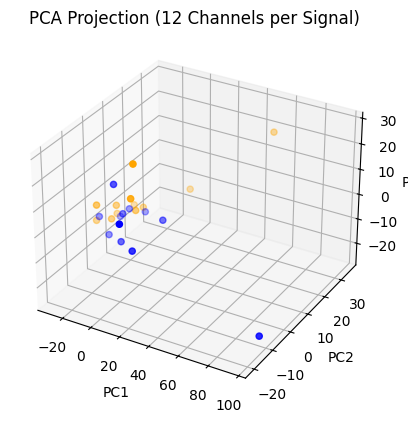

In [179]:
PCA_option_2(converted_to_angle_dict, 1, 4, 12).to_plot_3D_scatter()

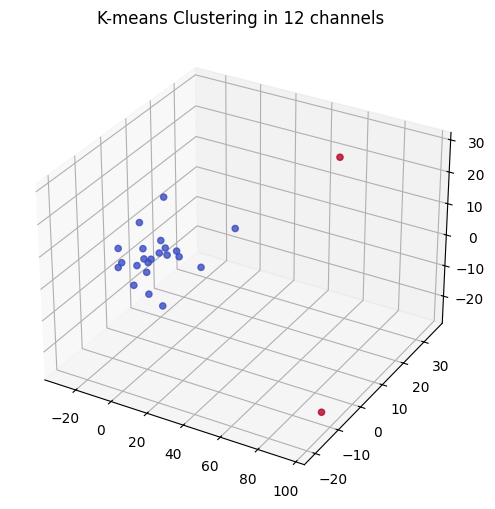

In [180]:
PCA_option_2(converted_to_angle_dict, 1, 4, 12).to_plot_KMean()

[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5384615384615384, 0.5357142857142857]


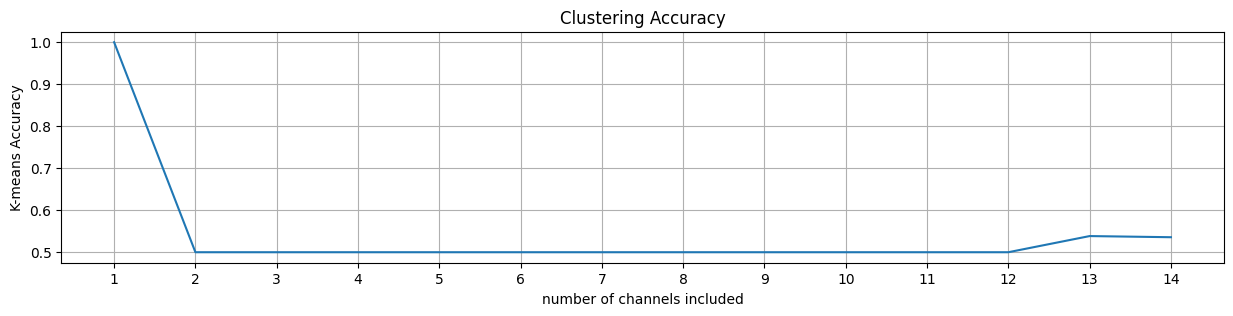

In [107]:
acc_cluster = []
for ch in range(1, len(channel_dict.keys())+1):
    acc = PCA_option_2(converted_to_angle_dict, 1, 4, ch).to_apply_KMean()[0]
    acc_cluster.append(acc)
print(acc_cluster)

plt.figure(figsize=(15, 3)) 
plt.plot(range(1, len(channel_dict.keys())+1), acc_cluster)
plt.xticks(range(1, len(channel_dict.keys())+1))  # Tick every 1 unit from 1 to 32
plt.xlabel('number of channels included')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy')
plt.grid(True)
plt.show()  